### PyTorch MNIST Example similar to TensorFlow Tutorial

Refer to https://www.tensorflow.org/versions/master/tutorials/mnist/pros/

PyTorch 0.1.12 and torchvision 0.1.7

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

- MnistNet inherit from nn.Module class.
- MnistNet must implement forward method.
- layers instantiated in \__init__, but actual graph is created in forward method.
- functional method like pooling, activation are in torch.nn.functional
- explicitly specify padding and stride, otherwise default padding=0, stride=1 applied
- Conv2d(in_channels, out_channels, kernel_size), weight/bias is uniform dist. with -1/sqrt(n_units)~+1/sqrt(n_units)
- Linear(in_features, out_features), weight/bias is uniform dist. with -1/sqrt(n_units)~+1/sqrt(n_units)
- model.conv1.weight, moedel.conv1.bias, .. etc
- dropout default prob. p=0.5 applied when training=True

In [4]:
## two 3x3 conv layers with Batch Normalization followed by 2 FC layers 

class MnistModel(nn.Module):
    def __init__(self): 
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=1 for same padding
        self.conv11 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(32, 32, kernel_size = 3, padding=1)
        self.conv11_bn = nn.BatchNorm2d(32)
        self.conv12_bn = nn.BatchNorm2d(32)

        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv21 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv21_bn = nn.BatchNorm2d(64)
        self.conv22_bn = nn.BatchNorm2d(64)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = self.conv11_bn(x)
        x = F.relu(self.conv12(x))
        x = self.conv12_bn(x)
        x = F.max_pool2d(x,2)
        
        x = F.relu(self.conv21(x))
        x = self.conv21_bn(x)
        x = F.relu(self.conv22(x))
        x = self.conv22_bn(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = MnistModel()
model = model.cuda()# training in GPU

- dataset.MNIST load train-images when train=True
- dataset.MNIST load t10k-images when train=False
- pixel value divided by 255 with tranform.ToTensor()

In [5]:
# set shuffle to false to preserve the ordering for submission file  
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
        batch_size=1000,shuffle=False)

In [6]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, 
                   transform=transforms.Compose([
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
                    batch_size=batch_size, shuffle=True)

- model.parameters return all weights and biases

In [7]:
for p in model.parameters():
    print(p.size())

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([1024, 3136])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

- model.train() makes training=True, model.eval() makes traingin=False

In [10]:
train_loss = []
train_accu = []
i = 0
num_epochs = 10
for epoch in range(num_epochs):
    for data, target in train_loader:
        model.train()
        data, target = data.cuda(), target.cuda() # to load into GPU
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.data[0])
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = (float(prediction.eq(target.data).sum())/float(batch_size))*100.0
        train_accu.append(accuracy)
        if i % 250 == 0: # 254 iterations ~~ 1 epoch
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data[0], accuracy))
        i += 1
    ## testing after every epoch
    
    model.eval()
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        prediction = output.data.max(1)[1]
        correct += prediction.eq(target.data).sum()
    print('\n epoch: {} Test set: Accuracy: {:.2f}%'.format(epoch, (100. * correct / len(test_loader.dataset))))
    save_name = 'model'+str(epoch)
    torch.save(model,save_name)

Train Step: 0	Loss: 0.004	Accuracy: 100.000

 epoch: 0 Test set: Accuracy: 99.24%


KeyboardInterrupt: 

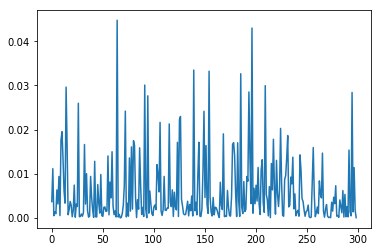

In [11]:
plt.plot(np.arange(len(train_loss)), train_loss)

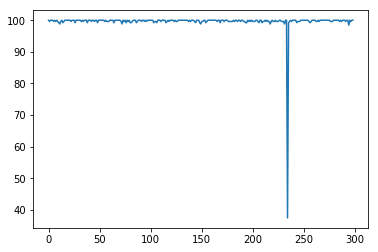

In [12]:
plt.plot(np.arange(len(train_accu)), train_accu)

- volatile=True is used in inference mode. it makes stopping histoy recording for backward().

In [14]:
# testing the model
import numpy as np

model = torch.load('model7')
model.eval()
correct = 0
pred = np.zeros((10000,1), dtype=int)


test_batch_size = 1000
index = 0
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    prediction = output.data.max(1)[1]
    # save predictions
    pred[index*test_batch_size:(index+1)*test_batch_size] = prediction.cpu().numpy()
    index+=1
    correct += prediction.eq(target.data).sum()
    
    
print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 99.32%


In [15]:
# saving the output into a submission file
import pandas as pd
print pred.shape
pred.resize(10000)
#print pred.shape
sample_file = '/home/gautam/Downloads/sample.csv'
df = pd.DataFrame.from_csv(sample_file,header=0,sep=',',index_col=None)
print df.columns
se = pd.Series(pred)
df['Category'] = se.values
df.to_csv('test_results.csv',index=None)

(10000, 1)
Index([u'Id', u'Category'], dtype='object')
